# U.S. Solar Power Output Time Series Analysis and Forecasting

**Aidan O'Keefe**

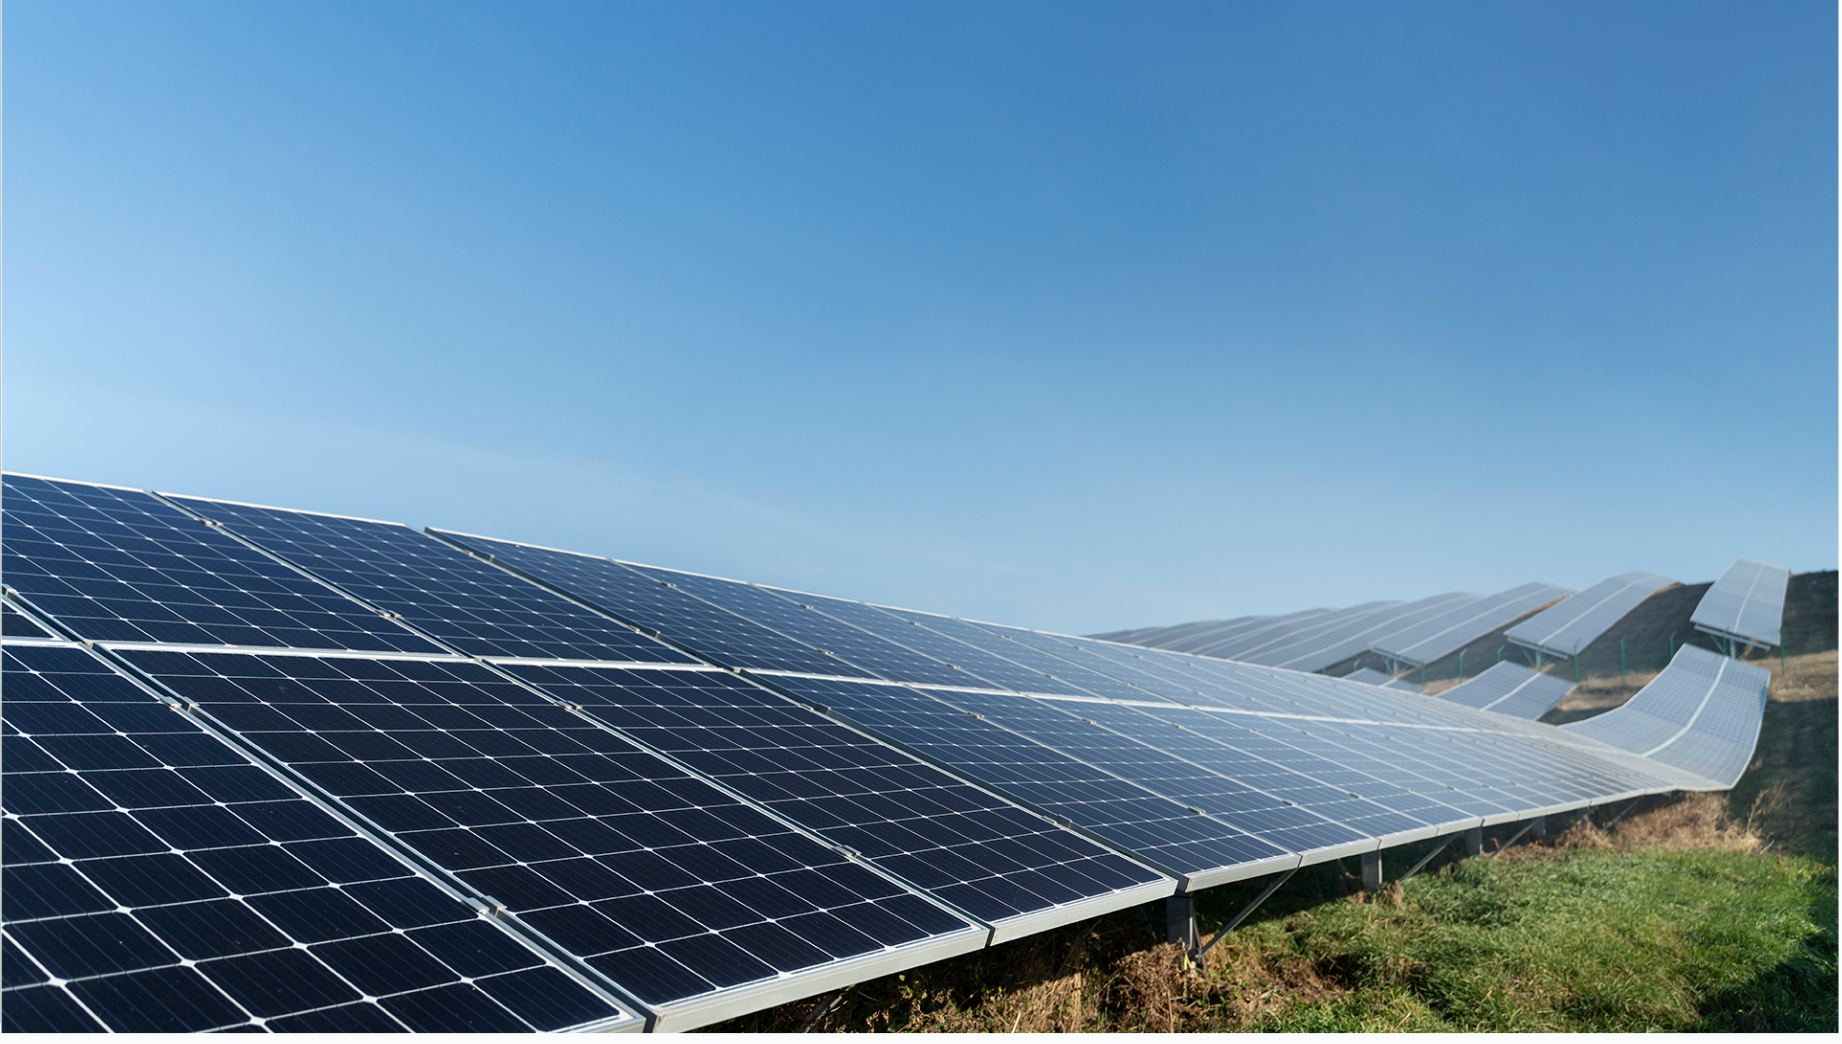 *Image provided by Freepik*

## Overview

Univariate time series analysis and modeling project of solar power output in the United States.

#### Business Overview
The North American Electric Reliability Corporation (NERC) regulates the electrical grid in the United States, Canada, and the northern part of Baja California, Mexico. They have asked us to try to forecast solar output in order to help them manage the US grid better.

#### Data Overview
Data for this project was taken from the U.S. Energy Information Administration's Electricy Data Browser. The data has monthly frequency from Jan 2001 to Dec 2022 of solar output in thousand megawatthours. Each row is a location with power output grouped by individual state, region, and US Total.

#### Methods Overview
To preprocess the data, I turned our raw csv into a datetime indexed dataframe of only Total US Solar Power Output. After trying to use rolling statistics, differencing and other transformations, I successfully stationarized the timeseries data using time series decomposition and confirmed stationarity using the Augmented Dickey-Fuller Test. I implemented a Naive model, a variety of SARIMAX/ARIMA models (including parameter search), and a Facebook Prophet model.

#### Evaluation Overview
An ARIMA (4,0,1) model was chosen as the final model based on it's AIC and RMSE. On test data, the final model had a RMSE of 0.033 thousand megawatthours and a MAPE of 2.32%. We then forecasted US Solar output 12 months out using our final ARIMA(4,0,1) model (as well as the FB Prophet model for comparison).

I would recommend that NERC consider testing this forecast in the next year and calculating errors to see if the model would be helpful moving forwad. I would reccommend adding in data on the number on power plants as well as environmental factors (weather, solar irradiation) so the model accounts for more external factors. In the future, I would look to repeat this time series modeling and forecasting at the regional and state level in order to provide more actionable data. 


## Business Problem

[The North American Electric Reliability Corporation (NERC)](https://www.nerc.com/Pages/default.aspx)  is "not-for-profit international regulatory authority whose mission is to assure the effective and efficient reduction of risks to the reliability and security of the grid." NERC regulates the electrical grid in the United States, Canada, and the northern part of Baja California, Mexico. 

Renewable energy production relies on natural factors like sun and wind and therefore their output is more varaible than traditional non-renewable energy. As renewable energy production increases, NERC wants to know how much power to expect from renewable sources. They have asked us to try to forecast solar output in order to help them manage the US grid better.

## Data Understanding

Data for this project was taken from the [U.S. Energy Information Administration's Electricy Data Browser](https://www.eia.gov/electricity/data/browser/#/topic/0?agg=1,2,0&fuel=0004&geo=vvvvvvvvvvvvo&sec=g&linechart=ELEC.GEN.TSN-US-99.M&columnchart=ELEC.GEN.TSN-US-99.M&map=ELEC.GEN.TSN-US-99.M&freq=M&start=200101&end=202212&ctype=map&ltype=pin&rtype=s&maptype=0&rse=0&pin=). 

As noted on the USEIA's data description:
*NM = Not meaningful due to large relative standard error.*
<br>
<br>The data has monthly frequency from Jan 2001 to Dec 2022 of solar output in thousand megawatthours. Each row is a location with power output grouped by individual state, region, and US Total.
<br> 
<br>In order to explain our unit of thousand megawatthours, consider a 100-watt rated lightbulb uses 100 watts per hour of operation. If 1,000 watts is 1 kilowatt, you could run that 100-watt lightbulb for 10 hours on 1 kilowatt. If 1,000 kilowatts is 1 megawatt, you could run that 100-watt lightbulb for 10,000 hours on 1 megawatt. Finally if 1000 megawatts is 1 thousand megawatts, you could have your 100-watt lightbulb on for 10 million hours in order to use 1 thousand megawatthour.

In [117]:
#Importing relevant libraries and tools

#Import standard libraries
import numpy as np
import pandas as pd
from scipy import stats as stats

#Import visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#Time-Series
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

#Stats Models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools

#Facebook Prophet
from prophet import Prophet

#View all columns in our dataframes
pd.options.display.max_columns = None
pd.options.display.width = None

import warnings
warnings.filterwarnings('ignore')

In [118]:
#Import our data and preview the first five rows

#ALL OF US SOLAR OUTPUT DATAFRAME
full_solar_df = \
pd.read_csv('/Users/Aidan/Documents/Flatiron/Phase_4/Solar_Power_Output_Time_Series/data/Net_generation_for_all_solar.csv',
            skiprows=4)

full_solar_df.head()

description                   units  \
0  Net generation for all solar  thousand megawatthours   
1                   All sectors  thousand megawatthours   
2   All sectors : United States  thousand megawatthours   
3     All sectors : New England  thousand megawatthours   
4     All sectors : Connecticut  thousand megawatthours   

              source key Jan 2001 Feb 2001 Mar 2001 Apr 2001 May 2001  \
0                    NaN      NaN      NaN      NaN      NaN      NaN   
1   ELEC.GEN.TSN-US-99.M      NaN      NaN      NaN      NaN      NaN   
2   ELEC.GEN.TSN-US-99.M       --       --       --       --       --   
3  ELEC.GEN.TSN-NEW-99.M       --       --       --       --       --   
4   ELEC.GEN.TSN-CT-99.M       --       --       --       --       --   

  Jun 2001 Jul 2001 Aug 2001 Sep 2001 Oct 2001 Nov 2001 Dec 2001 Jan 2002  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       --       --       --       --       --       --       --       --   
3       --       --       --       --       --       --       --       --   
4       --       --       --       --       --       --       --       --   

  Feb 2002 Mar 2002 Apr 2002 May 2002 Jun 2002 Jul 2002 Aug 2002 Sep 2002  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       --       --       --       --       --       --       --       --   
3       --       --       --       --       --       --       --       --   
4       --       --       --       --       --       --       --       --   

  Oct 2002 Nov 2002 Dec 2002 Jan 2003 Feb 2003 Mar 2003 Apr 2003 May 2003  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       --       --       --       --       --       --       --       --   
3       --       --       --       --       --       --       --       --   
4       --       --       --       --       --       --       --       --   

  Jun 2003 Jul 2003 Aug 2003 Sep 2003 Oct 2003 Nov 2003 Dec 2003 Jan 2004  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       --       --       --       --       --       --       --       --   
3       --       --       --       --       --       --       --       --   
4       --       --       --       --       --       --       --       --   

  Feb 2004 Mar 2004 Apr 2004 May 2004 Jun 2004 Jul 2004 Aug 2004 Sep 2004  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       --       --       --       --       --       --       --       --   
3       --       --       --       --       --       --       --       --   
4       --       --       --       --       --       --       --       --   

  Oct 2004 Nov 2004 Dec 2004 Jan 2005 Feb 2005 Mar 2005 Apr 2005 May 2005  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       --       --       --       --       --       --       --       --   
3       --       --       --       --       --       --       --       --   
4       --       --       --       --       --       --       --       --   

  Jun 2005 Jul 2005 Aug 2005 Sep 2005 Oct 2005 Nov 2005 Dec 2005 Jan 2006  \
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2       --       --       --       --       --       --       --       --   
3       --       --       --       --       --       --       --       --   
4       --       --       --       --       --       --       -

I had to skip the first 4 rows as our column headers did not start until row 5.

We do not need the first two rows with all the NaN values so let's drop them.

In [119]:
full_solar_df = full_solar_df.loc[2:,:]

In [120]:
full_solar_df.shape

(62, 267)

Currently we have 62 records. We'll have to cut it down to the row (or rows) we want.

In [121]:
full_solar_df.columns

Index(['description', 'units', 'source key', 'Jan 2001', 'Feb 2001',
       'Mar 2001', 'Apr 2001', 'May 2001', 'Jun 2001', 'Jul 2001',
       ...
       'Mar 2022', 'Apr 2022', 'May 2022', 'Jun 2022', 'Jul 2022', 'Aug 2022',
       'Sep 2022', 'Oct 2022', 'Nov 2022', 'Dec 2022'],
      dtype='object', length=267)

The 264 columns (starting with Jan 2001) will become our date time index. Before we do anymore EDA, we will have to start preprocessing the data.

## Data Preparation

First let's make a cleaned `Location` column from the `description` column.

In [122]:
#Remove "All Sectors : " from place name in the description column
full_solar_df['Location'] = [i[14:] for i in full_solar_df['description']]

#Drop the old 'description column', bring our new column to the left of our dataframe, and reset the index
full_solar_df = full_solar_df.drop('description', axis=1).set_index('Location').reset_index()

Let's separate our `full_solar_df` into a datafrane with just US Totals.

In [123]:
#Create a new dataframe using only the United States row, drop non-date columns, and transpose our dataframe
us_solar_df = full_solar_df[full_solar_df['Location'] == "United States"]\
.drop(['Location','units', 'source key'], axis =1).T

In [124]:
#Turn our new index of dates into datetime datatypes
us_solar_df.index = pd.to_datetime(us_solar_df.index, format="%b %Y")

In [125]:
#Rename our column with our values to Solar Output (thousand megawatthours)
us_solar_df.rename(columns = {0:'Solar Output (tmwh)'}, inplace=True)

In [126]:
#It looks like our column is properly labelled but its datatype is an object rather than number
us_solar_df.columns

Index(['Solar Output (tmwh)'], dtype='object')

In [127]:
#Let's check for missing values
us_solar_df.isna().sum()

Solar Output (tmwh)    0
dtype: int64

Looks like we do not have any missing value in our dataframe.

In [128]:
#Check for placeholder values
us_solar_df.value_counts().head(10)

Solar Output (tmwh)
--                     156
9997                     1
2171                     1
16891                    1
17042                    1
17304                    1
17384                    1
17520                    1
1798                     1
18786                    1
dtype: int64

Definitely looks like "--" is currently a placeholder for no output.

In [129]:
#Replace "--"  values meaning no Solar Ouput with 0
us_solar_df['Solar Output (tmwh)'].replace(to_replace='--', value=0, inplace=True)

#Check to see if we now have zeros instead of hyphens
us_solar_df['Solar Output (tmwh)']

2001-01-01        0
2001-02-01        0
2001-03-01        0
2001-04-01        0
2001-05-01        0
              ...  
2022-08-01    20352
2022-09-01    18786
2022-10-01    17042
2022-11-01    12336
2022-12-01    10534
Name: Solar Output (tmwh), Length: 264, dtype: object

In [130]:
#Changing our Solar Output column into integer datatypes
us_solar_df['Solar Output (tmwh)'] = us_solar_df['Solar Output (tmwh)'].astype(int)

In [131]:
#View our fully transformed dataframe
us_solar_df

Solar Output (tmwh)
2001-01-01                    0
2001-02-01                    0
2001-03-01                    0
2001-04-01                    0
2001-05-01                    0
...                         ...
2022-08-01                20352
2022-09-01                18786
2022-10-01                17042
2022-11-01                12336
2022-12-01                10534

[264 rows x 1 columns]

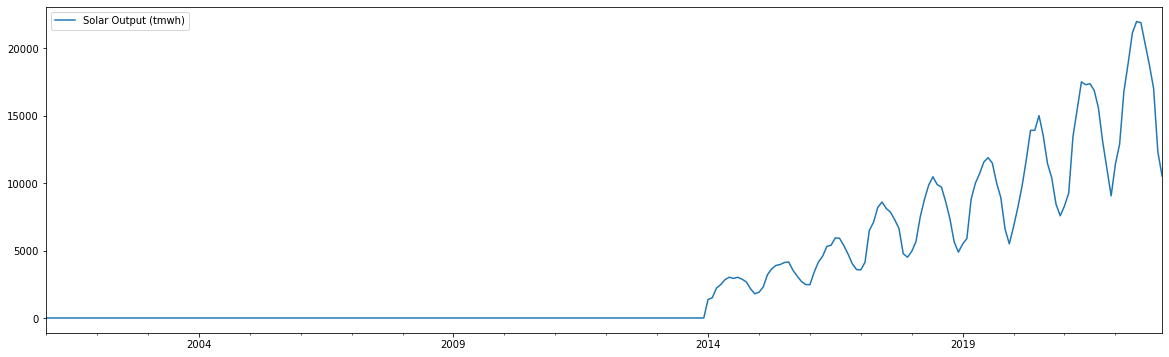

In [132]:
# Let's plot our new dataframe to see what our data looks like
us_solar_df.plot(figsize = (20,6));

There doesn't seem to be any solar power output in the US before 2014. Let's zoom in to our data after that point. 

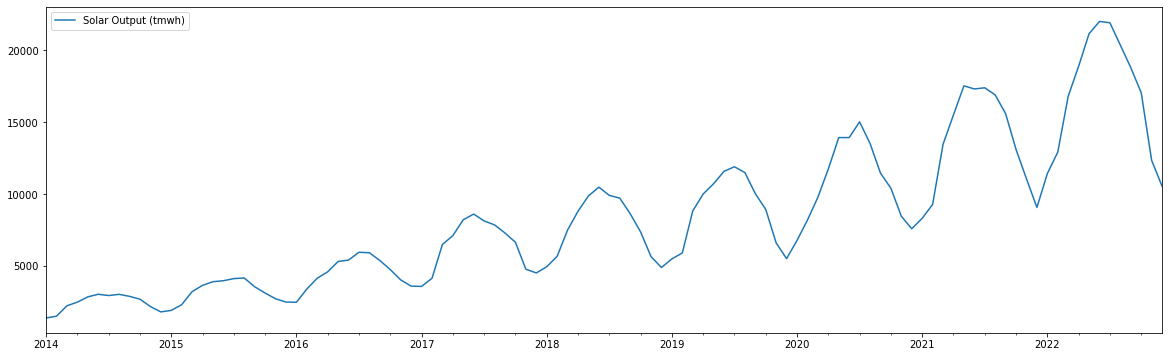

In [133]:
#New dataframe limited to Jan 2014 and afterwards.
us_solar_df = us_solar_df.loc['2014-01-01':]

#Plot our data
us_solar_df.plot(figsize = (20,6));

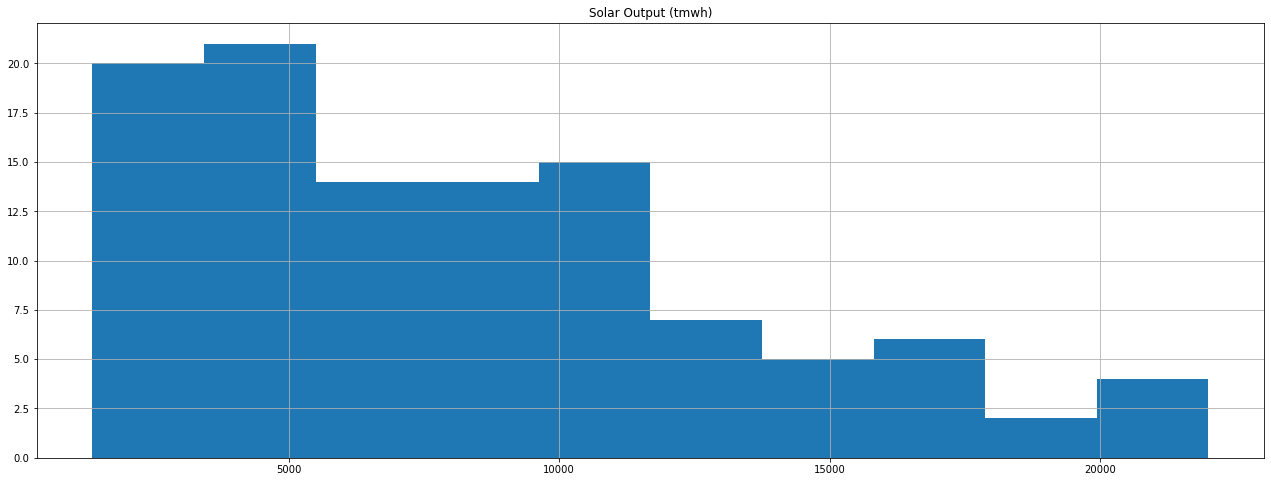

In [134]:
# Plot a histogram for US Solar dataset
us_solar_df.hist(figsize = (22,8), bins= 10);

Our ouput values are skewed to the right, which makes sense as the solar ouput is increasing over time so less time has passed where output was large. A density plot may be more useful in showing the overall shape of the data.

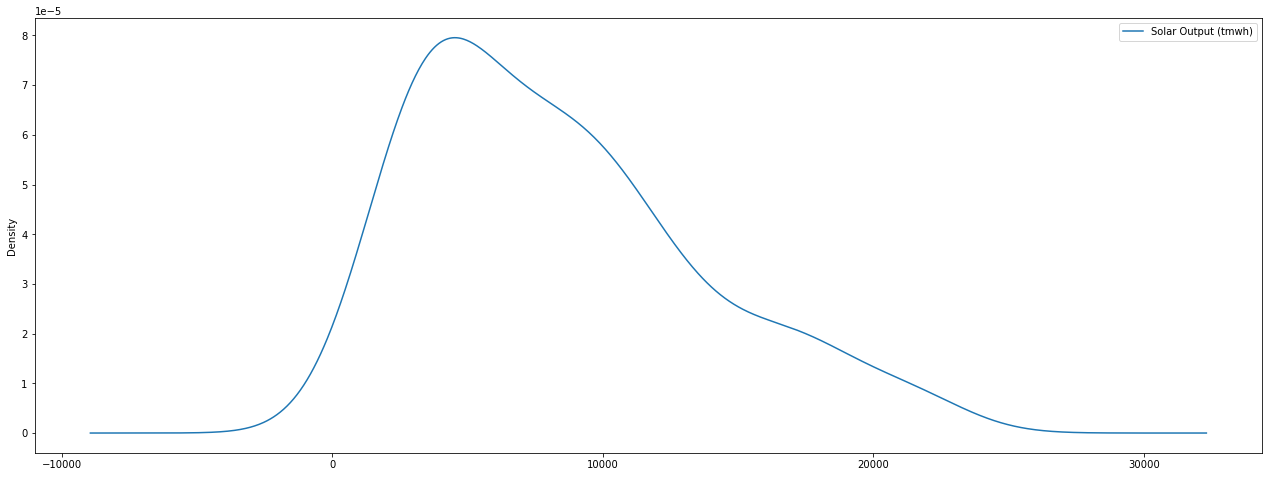

In [135]:
# Plot a density plot for US Solar dataset
us_solar_df.plot(figsize = (22,8), kind='kde');

Let's take a look at trends by year.

In [136]:
#Group by year
us_year_groups = us_solar_df.groupby(pd.Grouper(freq ='Y'))

# Create a new DataFrame and store yearly values in columns 
us_solar_annual = pd.DataFrame() 

for yr, group in us_year_groups:
    us_solar_annual[yr.year] = group.values.ravel()

In [137]:
us_solar_annual.columns

Int64Index([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], dtype='int64')

In the new dataframe above, the rows represent months with the column representing years.

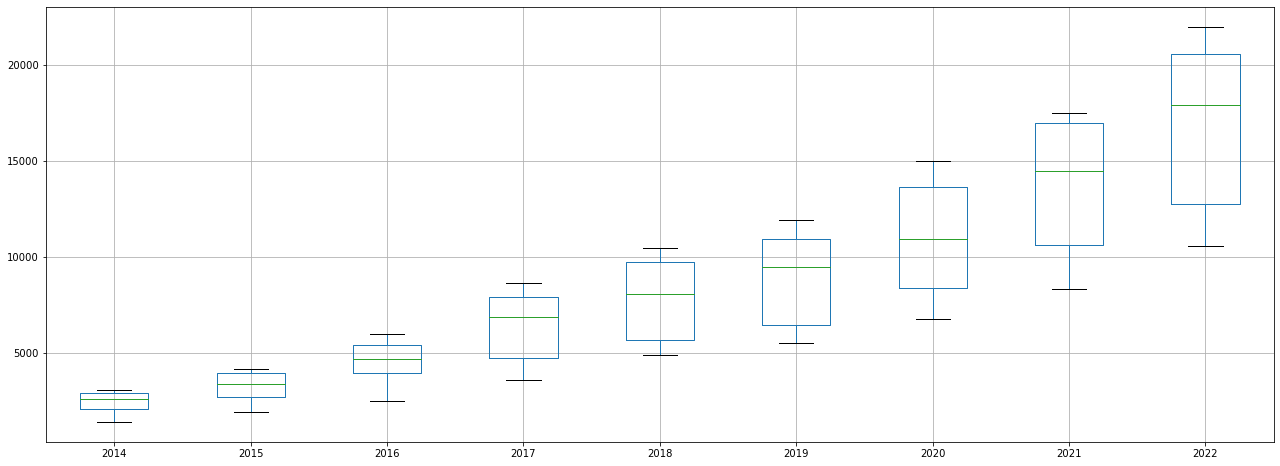

In [138]:
# Generate a box and whiskers plot for us_solar_annual 
us_solar_annual.boxplot(figsize = (22,8));

We know there is seasonality so we may want to look at month data for single years.

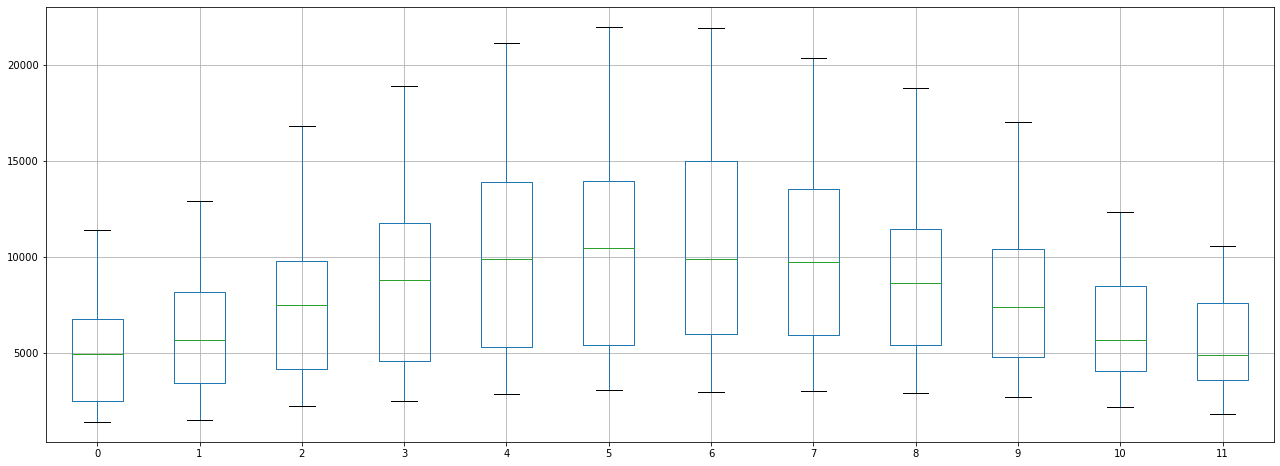

In [139]:
#Transpose to group by months
us_solar_annual.T.boxplot(figsize = (22,8));

Shows a curve in the data with US solar output highest in the summer months: June (Index 5) and July (Index 6). 

In [140]:
#Group by month
us_month_groups = us_solar_df.groupby(pd.Grouper(freq ='M'))

# Create a new DataFrame and store monthly values in columns 
us_solar_month = pd.DataFrame() 

for month, group in us_month_groups:
    us_solar_month[month.month] = group.values.ravel()

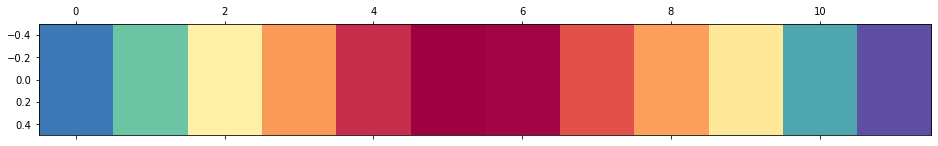

In [141]:
# Draw a heatmap with matshow()
plt.matshow(us_solar_month, aspect='auto', cmap=plt.cm.Spectral_r);

The above culmulative heatmap confirms the curve of output increasing in summer months.

### Test for Stationarity

In order for the data to be staionary, it needs to fit the following three criterias:
- Constant mean (no trend)
- Constant variance (no heteroskedasticity)
- Constant covariance (no change in spread)

We can test for stationarity in using two different methods: **Rolling Statistics** and the **Augmented Dickey-Fuller statistical test**.

In [142]:
#Calculate rolling statistics. Using a window of 12 for months in a year
us_roll_mean = us_solar_df.rolling(window=12, center=False).mean()
us_roll_std = us_solar_df.rolling(window=12, center=False).std()

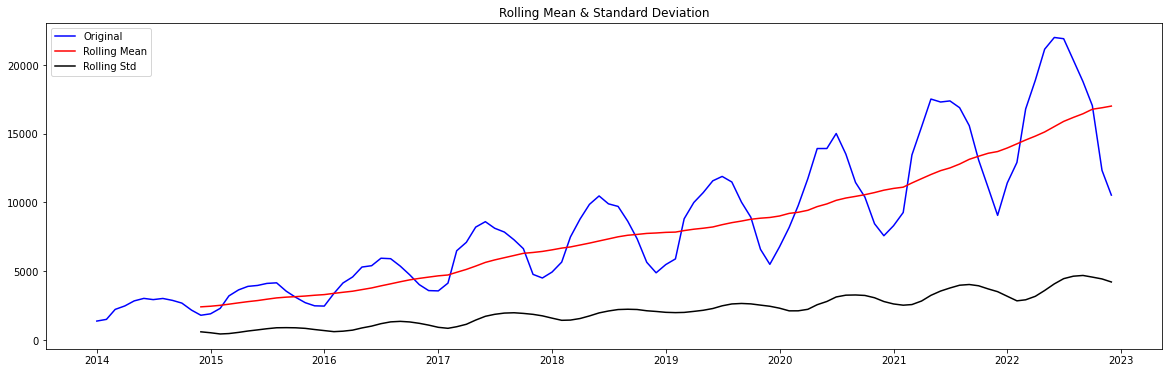

In [143]:
#Plot our rolling statistics along with our original data
fig = plt.figure(figsize=(20,6))
plt.plot(us_solar_df, color='blue', label='Original')
plt.plot(us_roll_mean, color='red', label='Rolling Mean')
plt.plot(us_roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From simply looking at the data, we can see there is an upward linear trend and a periodic trend as well as increasing variance. The rolling statistics show us that the mean is increasing considerably over time and variance (standard deviation) is also increasing at a slower rate. Even though we can tell it's not stationary, let's perform a statistical test (Augemented Dickey-Fuller Test) to be sure. 

In [144]:
#Perform an Augmented Dickey-Fuller Test

# Extract and display test results in a user friendly manner
def df_printout(data):
    dftest= adfuller(data)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [145]:
#View test results on original data
df_printout(us_solar_df)

ADF Test Statistic              2.525349
p-value                         0.999058
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


The null-hypothesis for the Dickey-Fuller test is that the time series is not stationary. So if the test statistic is less than the critical value or if the p-value is less than the confidence level (0.05), we reject the null hypothesis and say that the series is stationary.<BR>
<BR>
With a p-value of 0.999, this time series cannot reject the null hypothesis and so is very much not stationary as we already had visaully deduced earlier.

### Eliminating trend/heteroskedasticity

Let's try a few different methods to stationarize our data.

#### Subtracting Rolling Mean

In [146]:
# Subtract the moving average from the original data
us_solar_minus_roll_mean = us_solar_df - us_roll_mean
us_solar_minus_roll_mean.head(15)

Solar Output (tmwh)
2014-01-01                  NaN
2014-02-01                  NaN
2014-03-01                  NaN
2014-04-01                  NaN
2014-05-01                  NaN
2014-06-01                  NaN
2014-07-01                  NaN
2014-08-01                  NaN
2014-09-01                  NaN
2014-10-01                  NaN
2014-11-01                  NaN
2014-12-01          -612.416667
2015-01-01          -552.333333
2015-02-01          -222.000000
2015-03-01           603.166667

In [147]:
# Drop the missing values from time series calculated above
us_solar_minus_roll_mean.dropna(inplace=True)

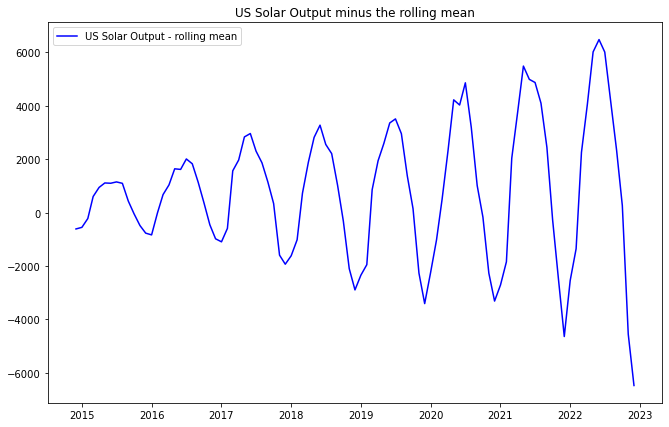

In [148]:
fig = plt.figure(figsize=(11,7))
plt.plot(us_solar_minus_roll_mean, color='blue',label='US Solar Output - rolling mean')
plt.legend(loc='best')
plt.title('US Solar Output minus the rolling mean')
plt.show(block=False)

In [149]:
#Perform A Dickey-Fuller Test
df_printout(us_solar_minus_roll_mean)

ADF Test Statistic             -0.470908
p-value                         0.897570
#Lags Used                     11.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64


Although we have dealt with the trend, we still have heteroskedasticity with variance increasing over time. The p-value of 0.897 reflects this and confirms it is not stationary.

#### Subtracting the Exponentially Weighted Moving Average (Weighted Rolling Mean)

In [150]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
us_solar_ewm = us_solar_df.ewm(halflife=12).mean()

In [151]:
#Subtract the EWMA from our original data
us_solar_minus_exp_roll_mean = us_solar_df - us_solar_ewm
us_solar_minus_exp_roll_mean.head()

Solar Output (tmwh)
2014-01-01             0.000000
2014-02-01            60.209867
2014-03-01           508.217721
2014-04-01           553.393431
2014-05-01           713.683580

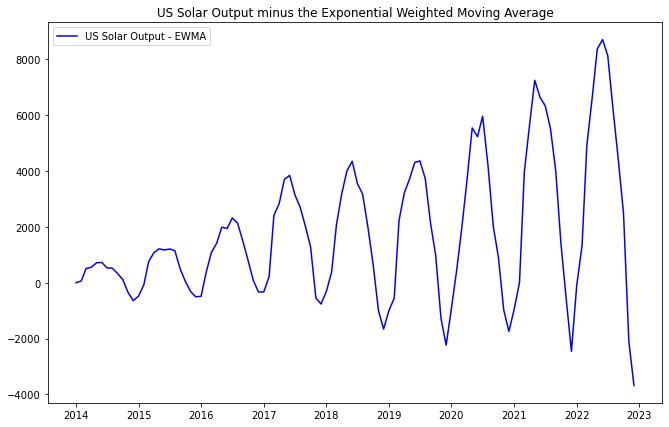

In [152]:
#Plot our transformed ewm data
fig = plt.figure(figsize=(11,7))
plt.plot(us_solar_minus_exp_roll_mean, color='blue',label='US Solar Output - EWMA')
plt.legend(loc='best')
plt.title('US Solar Output minus the Exponential Weighted Moving Average')
plt.show(block=False)

In [153]:
#Perform A Dickey-Fuller Test
df_printout(us_solar_minus_exp_roll_mean)

ADF Test Statistic              0.877279
p-value                         0.992787
#Lags Used                     11.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


A very similar result as the first method, there is still heteroskedasticity with variance increasing over time. The p-value of 0.992 fails to reject the null hypothesis so this transformation is not stationary.

#### Differencing

In [154]:
us_solar_diff = us_solar_df.diff(periods=1)
us_solar_diff.head(10)

Solar Output (tmwh)
2014-01-01                  NaN
2014-02-01                124.0
2014-03-01                725.0
2014-04-01                252.0
2014-05-01                366.0
2014-06-01                182.0
2014-07-01                -88.0
2014-08-01                 83.0
2014-09-01               -140.0
2014-10-01               -197.0

In [155]:
us_solar_diff.dropna(inplace=True)

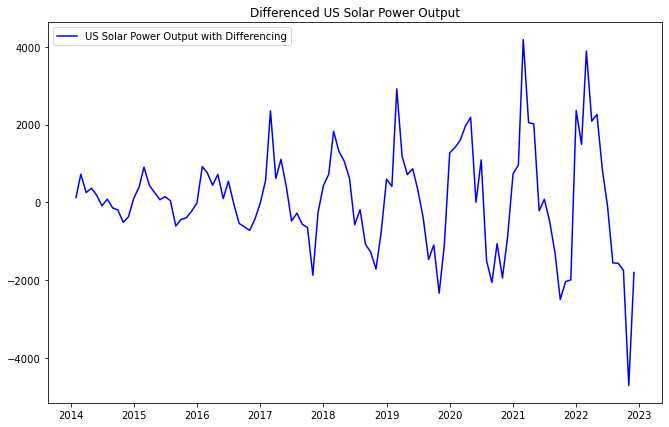

In [156]:
fig = plt.figure(figsize=(11,7))
plt.plot(us_solar_diff, color='blue',label='US Solar Power Output with Differencing')
plt.legend(loc='best')
plt.title('Differenced US Solar Power Output')
plt.show(block=False)

In [157]:
#Perform A Dickey-Fuller Test
df_printout(us_solar_diff)

ADF Test Statistic             -1.330986
p-value                         0.614880
#Lags Used                     13.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


Much like our rolling mean subtraction transformations, we still have heteroskedasticity with variance increasing over time. The p-value of 0.614 also confirms this transformed data is not stationary.

#### Log Transformation

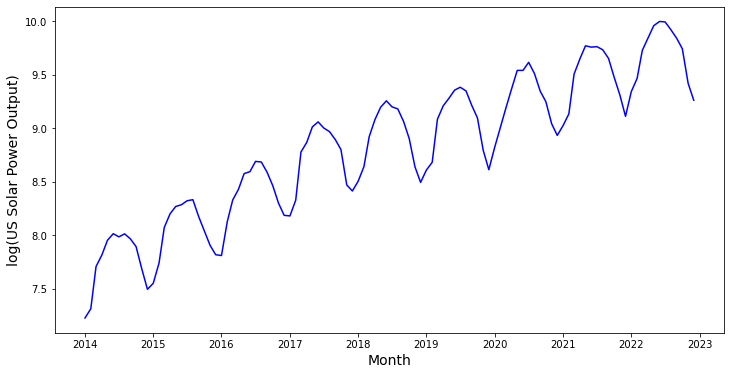

In [158]:
#Log Transform the data
us_solar_log = np.log(us_solar_df)

#Plot the data
fig = plt.figure(figsize=(12,6))
plt.plot(us_solar_log, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(US Solar Power Output)', fontsize=14)
plt.show()

In [159]:
#Perform A Dickey-Fuller Test
df_printout(us_solar_log)

ADF Test Statistic             -1.876097
p-value                         0.343388
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


The log transformation seemed to really get rid of heteroskedasticity, however we can clearly see there is still an upward linear trend in our data. The p-value of 0.34 is much lower than previous transformations but not low enough to ensure stationarity.

#### Square Root Transformation

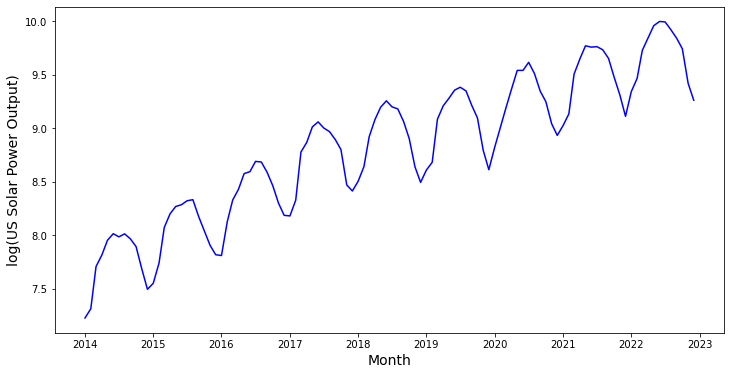

In [160]:
#Square Root Transform the data
us_solar_sqrt = np.sqrt(us_solar_df)

#Plot the data
fig = plt.figure(figsize=(12,6))
plt.plot(us_solar_log, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(US Solar Power Output)', fontsize=14)
plt.show()

In [161]:
#Perform A Dickey-Fuller Test
df_printout(us_solar_sqrt)

ADF Test Statistic              0.787054
p-value                         0.991424
#Lags Used                     13.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


This transformation looks similar to our log transformation, however the p-value of 0.991 is not much different from our untransformed data's p-value. The visible trend and p-value show it is very much not stationary.

#### Time Series Decomposition

Let's try another technique were we us a decomposition function to split our data into trend, seasonality, and noise (residuals).

##### Decomposition on Original Data

Our original data seems to have Multiplicative seasonality, meaning that seasonality (variance) increases in magnitude over time. 

In [162]:
#Decompose our original data
decomposition = seasonal_decompose(us_solar_df, model='multiplicative')
decomposition

In [163]:
# Save the trend, seasonality and noise of decomposed object as variables
trend = decomposition.trend
seasonality = decomposition.seasonal
noise = decomposition.resid

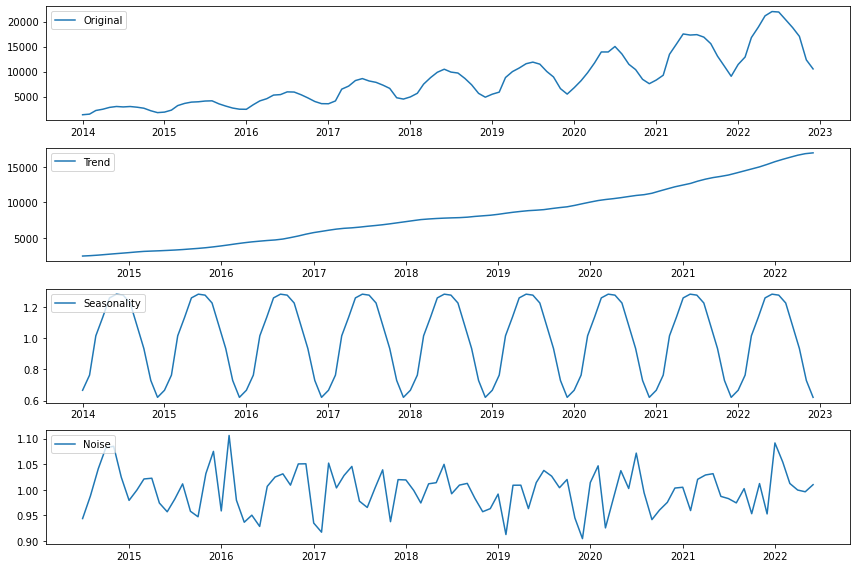

In [164]:
# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(us_solar_df, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(noise, label='Noise')
plt.legend(loc='upper left')
plt.tight_layout()

In [165]:
# Drop NaN values from residuals.
us_solar_decompose = noise
us_solar_decompose.dropna(inplace=True)

In [166]:
#Check for stationarity with the Dickey-Fuller Test
df_printout(us_solar_decompose)

ADF Test Statistic             -5.578232
p-value                         0.000001
#Lags Used                      7.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


This seemed to work really well removing trend and seasonality and left us with noise data with a p-value of 0.000001 that is well below 0.05. We can now reject the null hypothesis that the data is not stationary in favor of the alternative that the data is stationary.

##### Decomposition on Log Transformed Data

For curiousity's sake, let's try another transformation for stationarity.<br>
<br>
Since Log Transforming our data lowered our p-value the most, let's try decomposition again but using our log transformed data this time. The log transformed data seemed to have Additive seasonality, meaning that seasonality (variance) does not increase in magnitude over time. 

In [167]:
#Decompose our log transformed data
decomposition = seasonal_decompose(us_solar_log, model='additive')
decomposition

In [168]:
# Save the trend, seasonality and noise of decomposed object as  variables
trend = decomposition.trend
seasonality = decomposition.seasonal
noise = decomposition.resid

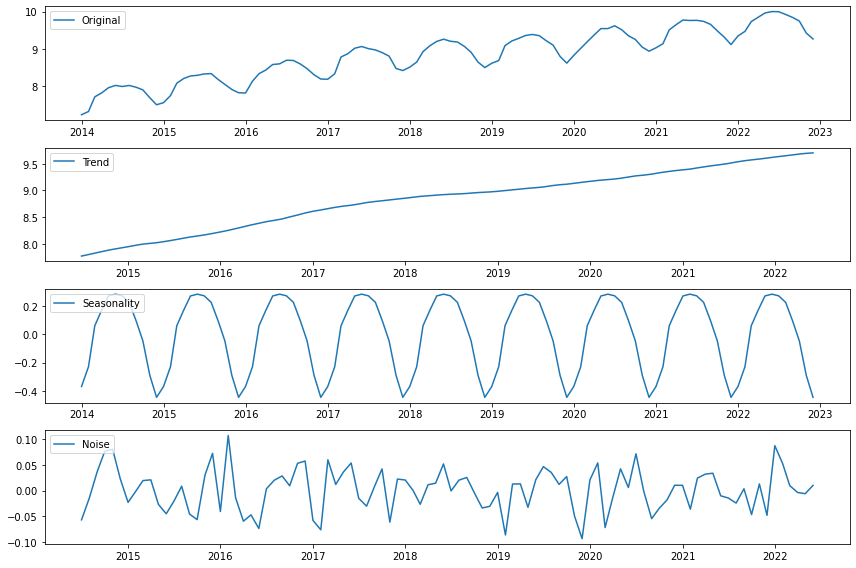

In [169]:
# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(us_solar_log, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(noise, label='Noise')
plt.legend(loc='upper left')
plt.tight_layout()

In [170]:
# Drop NaN values from residuals.
us_solar_log_decompose = noise
us_solar_log_decompose.dropna(inplace=True)

In [171]:
#Check for stationarity with the Dickey-Fuller Test
df_printout(us_solar_log_decompose)

ADF Test Statistic            -5.934232e+00
p-value                        2.341465e-07
#Lags Used                     7.000000e+00
Number of Observations Used    8.800000e+01
Critical Value (1%)           -3.506944e+00
Critical Value (5%)           -2.894990e+00
Critical Value (10%)          -2.584615e+00
dtype: float64


This transformation seemed to be extremely effective at making our data stationary with an even lower p-value of 2.341465e-07. However, we could also be transforming our data too much which could make it hard to model. 

## Modeling

### Train-Test Split

Before we begin modeling, we need to separate our data into train and test sets so that we can test our model before forecasting. With Time Series data, there is an order so we will have to split the data so the 20% most recent data is kept as a test set.

In [172]:
# find the index which allows us to split off 20% of the data
cutoff = round(us_solar_decompose.shape[0]*0.8)
cutoff

77

In [173]:
# Define train and test sets according to the index found above
train = us_solar_decompose[:cutoff]

test = us_solar_decompose[cutoff:]

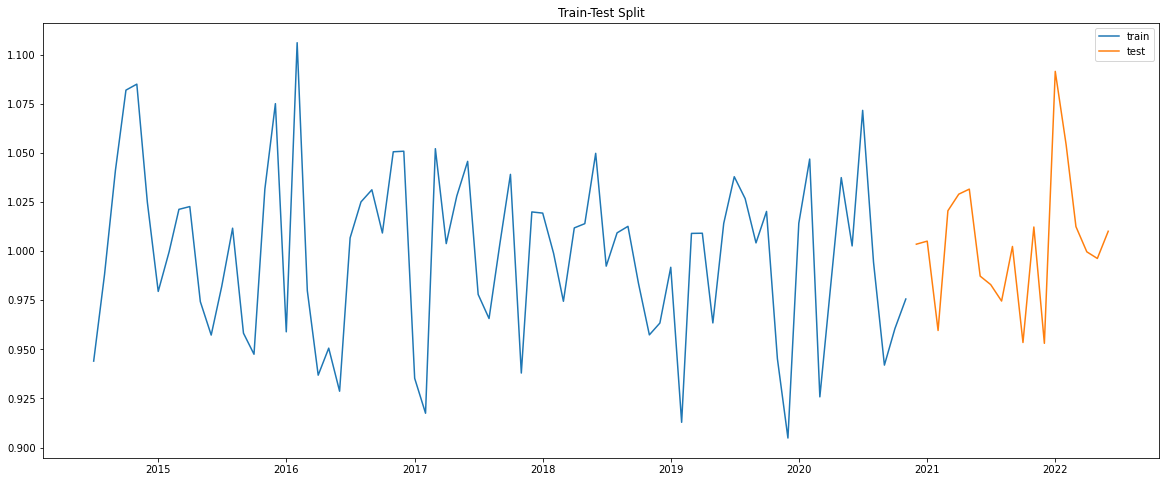

In [174]:
# Plot of our train test split
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

### Baseline Understanding

Our baseline understanding is that the best predictor for today's value is yesterday's value. We will shift our data over 1 lag to create a Naive Model as a baseline model.

In [175]:
# Naive Forecasting: basing our prediction for a month on the previous month's output
naive = train.shift(1)
naive

2014-07-01         NaN
2014-08-01    0.943989
2014-09-01    0.988181
2014-10-01    1.041097
2014-11-01    1.081964
                ...   
2020-07-01    1.002632
2020-08-01    1.071664
2020-09-01    0.994327
2020-10-01    0.941950
2020-11-01    0.960551
Name: resid, Length: 77, dtype: float64

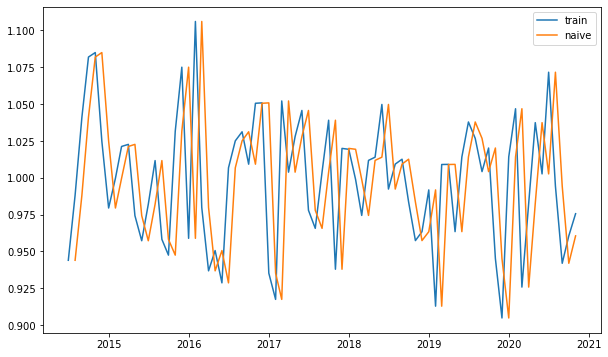

In [176]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(train, label= "train")
ax.plot(naive, label= "naive")
ax.legend();

In [177]:
#Root Mean Square Error(RMSE) For our baseline model

Naive_rmse = mean_squared_error(train[1:], naive.dropna(), squared=False)

print(Naive_rmse)

0.05602369702973403


INTERPRETATION OF RESULTS

### First  Model - Random Walk Model

Let's try one of the simpliest models in Time Series first, a random walk model, which only has 1 differenced term.

In [178]:
# Fit an ARIMA(0,1,0) model
RandWalk = ARIMA(train, order=(0,1,0)).fit()

# Print out summary information on the fit
print(RandWalk.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 111.191
Date:                Wed, 29 Mar 2023   AIC                           -220.382
Time:                        15:26:16   BIC                           -218.052
Sample:                    07-01-2014   HQIC                          -219.451
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0031      0.000      6.422      0.000       0.002       0.004
Ljung-Box (L1) (Q):                   7.56   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.01   Pr

In [179]:
#Root Mean Square Error(RMSE) For our Random Walk model
y_hat_rw = RandWalk.predict(typ='levels')

RandWalk_rmse = mean_squared_error(train, y_hat_rw, squared=False)

print(RandWalk_rmse)

0.12112313353103789


INTERPRET RESULTS

### Modeling Iterations

### Second  Model- AR(1)

Let's try a very simple Autoregression model using only 1 previous value.

In [180]:
# Fit an ARIMA(1,0,0) model
AR1 = ARIMA(train, order=(1,0,0)).fit()

# Print out summary information on the fit
print(AR1.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 133.891
Date:                Wed, 29 Mar 2023   AIC                           -261.781
Time:                        15:26:16   BIC                           -254.750
Sample:                    07-01-2014   HQIC                          -258.969
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9981      0.006    175.230      0.000       0.987       1.009
ar.L1          0.1527      0.108      1.408      0.159      -0.060       0.365
sigma2         0.0018      0.000      5.518      0.0

In [181]:
#Root Mean Square Error(RMSE) For our first 'substandard' model
y_hat_ar1 = AR1.predict(typ='levels')

AR1_rmse = mean_squared_error(train, y_hat_ar1, squared=False)

print(AR1_rmse)

0.042524002873012424


INTERPRET RESULTS

### Third Model- MA(1)

Let's try a very simple Moving Average model using only 1 previous error.

In [182]:
# Fit an ARMA(0,0,10) model
MA1 = ARIMA(train, order=(0,0,1)).fit()

# Print out summary information on the fit
print(MA1.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 134.448
Date:                Wed, 29 Mar 2023   AIC                           -262.896
Time:                        15:26:16   BIC                           -255.864
Sample:                    07-01-2014   HQIC                          -260.083
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9981      0.006    165.896      0.000       0.986       1.010
ma.L1          0.2488      0.102      2.429      0.015       0.048       0.450
sigma2         0.0018      0.000      5.619      0.0

In [183]:
#Root Mean Square Error(RMSE) For our MA(1) model
y_hat_ma1 = MA1.predict(typ='levels')

MA1_rmse = mean_squared_error(train, y_hat_ma1, squared=False)

print(MA1_rmse)

0.042222312488392796


INTERPRET RESULTS

### Fourth Model- ARMA(1,0,1)

Let's combine our 2nd and 3rd models and try an ARMA model with 1 AR and 1 MA term.

In [184]:
# Fit an ARMA(1,0,1) model
ARMA101 = ARIMA(train, order=(1,0,1)).fit()

# Print out summary information on the fit
print(ARMA101.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 135.726
Date:                Wed, 29 Mar 2023   AIC                           -263.452
Time:                        15:26:16   BIC                           -254.077
Sample:                    07-01-2014   HQIC                          -259.702
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9982      0.005    182.210      0.000       0.987       1.009
ar.L1         -0.5458      0.262     -2.084      0.037      -1.059      -0.032
ma.L1          0.7739      0.209      3.704      0.0

In [185]:
#Root Mean Square Error(RMSE) For our ARMA(1,0,1) model
y_hat_arma101 = ARMA101.predict(typ='levels')

ARMA101_rmse = mean_squared_error(train, y_hat_arma101, squared=False)

print(ARMA101_rmse)

0.04153042528185087


INTERPRET RESULTS

### Models based on ACF/PACF

#### ACF/PCF on Original Data

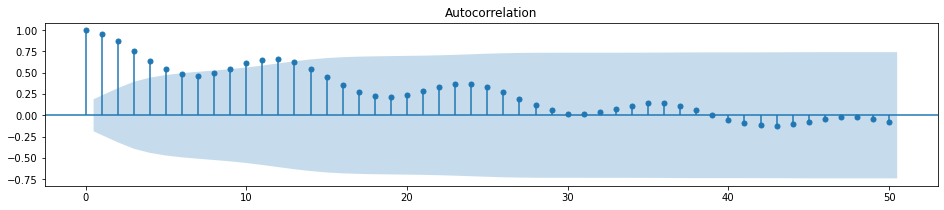

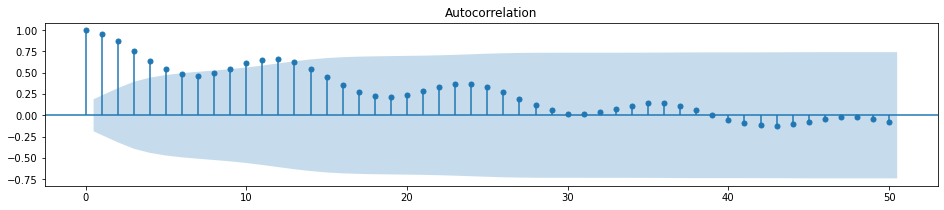

In [186]:
# Plot the ACF for original data
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(us_solar_df, ax=ax, lags=50)

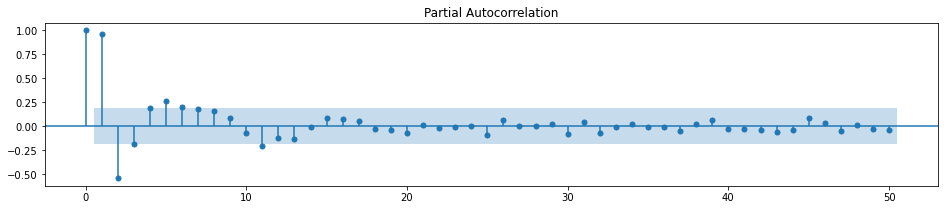

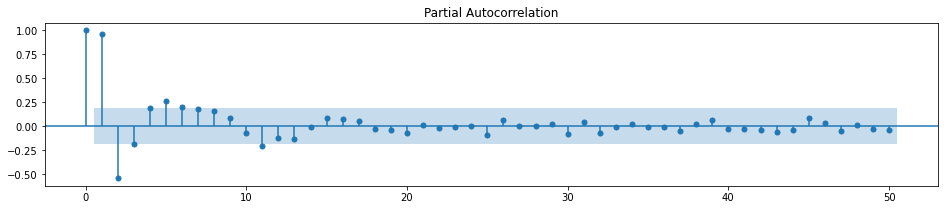

In [187]:
# Plot the PACF for original data
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(us_solar_df, ax=ax, lags=50, method='ywm')

Looking at our ACF and PACF plots above we can see some correlations. 
<br>
<br>
On the ACF, there are significant correlations up to 5 lags and then again at lag 10, 11, and 12. This definitely is reflecting the seasonality of the data. The lag at 12 shows that our data is correlated with its values from the year before (i.e. This Summer's values correspond with last Summer's values).
<br>
<br>
On the PACF, there are significant correlations at lags 1 (positive), 2 (negative), and possibly 3 (negative).

#### ACF/PCF on decomposed data

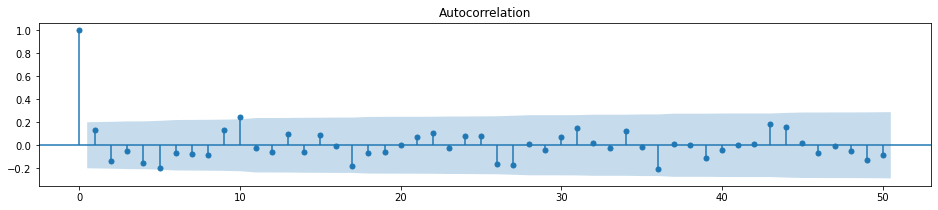

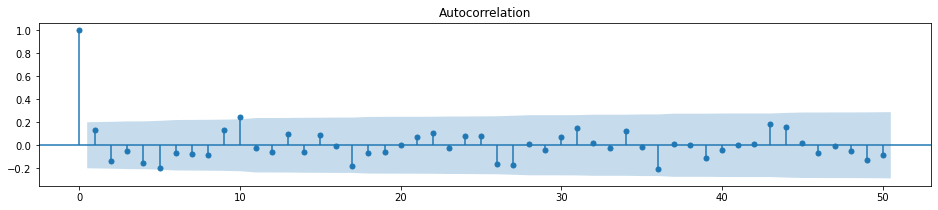

In [188]:
# Plot the ACF for decomposed data
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(us_solar_decompose, ax=ax, lags=50)

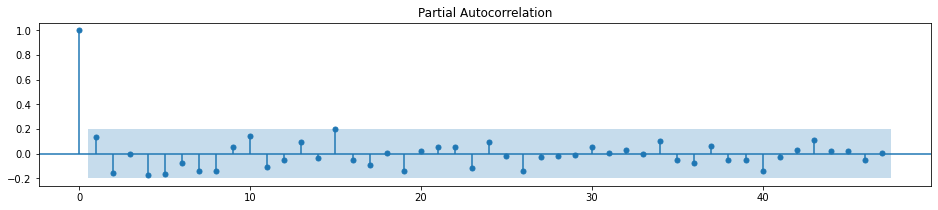

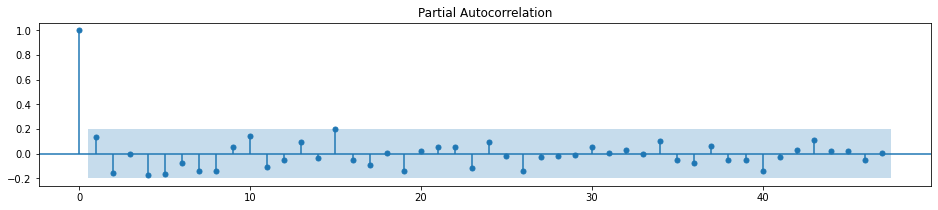

In [189]:
# Plot the PACF for decomposed data
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(us_solar_decompose, ax=ax, lags=47, method='ywm')

Our ACF and PACF plots of our decomposed data looks like a White Noise model with no correlations at all. This makes sense as it is a plot of the noise/residuals after our decomposition. 

### Fifth Model- AR(2)

Let's try an Autoregressive model at 2 lags where there was a strong negative correlation in the original data.

In [190]:
# Fit an ARMA(2,0,0) model
AR2 = ARIMA(train, order=(2,0,0)).fit()

# Print out summary information on the fit
print(AR2.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 135.353
Date:                Wed, 29 Mar 2023   AIC                           -262.706
Time:                        15:26:18   BIC                           -253.331
Sample:                    07-01-2014   HQIC                          -258.956
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9984      0.005    203.550      0.000       0.989       1.008
ar.L1          0.1810      0.104      1.735      0.083      -0.024       0.386
ar.L2         -0.1939      0.124     -1.561      0.1

In [191]:
#Root Mean Square Error(RMSE) For our AR(2) model
y_hat_ar2 = AR2.predict(typ='levels')

AR2_rmse = mean_squared_error(train, y_hat_ar2, squared=False)

print(AR2_rmse)

0.041720671820569474


INTERPRET RESULTS

### Sixth Model- AR(3)

Let's explore an AR(3) model since our original data had a significant negative correlation at lag 3.

In [192]:
# Fit an ARMA(3,0,0) model
AR3 = ARIMA(train, order=(3,0,0)).fit()

# Print out summary information on the fit
print(AR3.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 135.433
Date:                Wed, 29 Mar 2023   AIC                           -260.867
Time:                        15:26:18   BIC                           -249.148
Sample:                    07-01-2014   HQIC                          -256.179
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9983      0.005    192.479      0.000       0.988       1.008
ar.L1          0.1906      0.111      1.719      0.086      -0.027       0.408
ar.L2         -0.2014      0.126     -1.604      0.1

In [193]:
#Root Mean Square Error(RMSE) For our AR(3) model
y_hat_ar3 = AR3.predict(typ='levels')

AR3_rmse = mean_squared_error(train, y_hat_ar3, squared=False)

print(AR3_rmse)

0.041676805436199296


INTERPRET RESULTS

### Seventh Model- MA(2)

A drop to a negative correlation at lag 2 could also indicate an MA term is best. Let's try it out.

In [194]:
# Fit an ARMA(0,0,2) model
MA2 = ARIMA(train, order=(0,0,2)).fit()

# Print out summary information on the fit
print(MA2.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(0, 0, 2)   Log Likelihood                 136.086
Date:                Wed, 29 Mar 2023   AIC                           -264.172
Time:                        15:26:18   BIC                           -254.796
Sample:                    07-01-2014   HQIC                          -260.422
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9984      0.005    215.475      0.000       0.989       1.008
ma.L1          0.1838      0.110      1.675      0.094      -0.031       0.399
ma.L2         -0.2414      0.150     -1.614      0.1

In [195]:
#Root Mean Square Error(RMSE) For our MA(2) model
y_hat_ma2 = MA2.predict(typ='levels')

MA2_rmse = mean_squared_error(train, y_hat_ma2, squared=False)

print(MA2_rmse)

0.041325678553057306


INTERPRET RESULTS

### Eighth Model- MA(5)

On the ACF plot of original data, there were significant correlations up to 5 lags so let's try 5 error terms. 

In [196]:
# Fit an ARMA(0,0,5) model
MA5 = ARIMA(train, order=(0,0,5)).fit()

# Print out summary information on the fit
print(MA5.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(0, 0, 5)   Log Likelihood                 138.882
Date:                Wed, 29 Mar 2023   AIC                           -263.765
Time:                        15:26:18   BIC                           -247.358
Sample:                    07-01-2014   HQIC                          -257.202
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9981      0.002    612.336      0.000       0.995       1.001
ma.L1          0.0837      0.115      0.728      0.466      -0.142       0.309
ma.L2         -0.3212      0.136     -2.366      0.0

In [197]:
#Root Mean Square Error(RMSE) For our MA(5) model
y_hat_ma5 = MA5.predict(typ='levels')

MA5_rmse = mean_squared_error(train, y_hat_ma5, squared=False)

print(MA5_rmse)

0.03992607447706315


INTERPRET RESULTS

### Ninth Model- MA(12)

On the ACF plot, there were significant correlations at lag 10, 11, and peaking at 12. Let's try 12 lags.

In [198]:
# Fit an ARMA(0,0,12) model
MA12 = ARIMA(train, order=(0,0,12)).fit()

# Print out summary information on the fit
print(MA12.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                ARIMA(0, 0, 12)   Log Likelihood                 145.107
Date:                Wed, 29 Mar 2023   AIC                           -262.214
Time:                        15:26:20   BIC                           -229.401
Sample:                    07-01-2014   HQIC                          -249.089
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9982      0.003    398.152      0.000       0.993       1.003
ma.L1          0.1479      0.114      1.302      0.193      -0.075       0.370
ma.L2         -0.2603      0.162     -1.604      0.1

In [199]:
#Root Mean Square Error(RMSE) For our MA(12) model
y_hat_ma12 = MA12.predict(typ='levels')

MA12_rmse = mean_squared_error(train, y_hat_ma12, squared=False)

print(MA12_rmse)

0.03716449756236158


INTERPRET RESULTS

### Tenth Model- SARIMAX Parameter Selection

Let's run through a number of parameters to see what works best and gives us our lowest AIC score.

In [200]:
#Create list of SARIMAX parameters to test for pdq and PDQ (seasonal pdq)
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q 
# pdq = list(itertools.product(p, [0], q)) #No differencing since our decomposed data is stationary
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d, and q 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(pdq)]

In [201]:
# #Instantiate list to save model results to
# sarimax_param_combinations = []

# #Run through all iterations of parameters and return parameters with AIC Score
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             model = SARIMAX(train,
#                             order=param,
#                             seasonal_order=param_seasonal,
#                             enforce_stationarity=True,
#                             enforce_invertibility=True)
#             results = model.fit(disp=-1)
#             sarimax_param_combinations.append([param, param_seasonal, results.aic])
#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
#         except: 
#             print('Did not run model')
#             break

In [202]:
# # Find the parameters with minimal AIC value
# sarimax_param_combinations_df = pd.DataFrame(sarimax_param_combinations, columns=['pdq', 'pdqs', 'aic'])
# sarimax_param_combinations_df.loc[sarimax_param_combinations_df['aic'].idxmin()]

In [203]:
# Fit an SARIMAX(1,0,1)x(0,0,0,12) model (-250.411 AIC expected) w False Stationarity/Invertability
# Fit an SARIMAX(0,1,2)x(1,0,1,12) model (-254.996 AIC expected) w True Stationarity/Invertability
SARIMAX101 = SARIMAX(train, order=(1,0,1)).fit()

# Print out summary information on the fit
print(SARIMAX101.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 127.177
Date:                Wed, 29 Mar 2023   AIC                           -248.355
Time:                        15:26:20   BIC                           -241.323
Sample:                    07-01-2014   HQIC                          -245.542
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.08e-06   9.27e+05      0.000       1.000       1.000
ma.L1         -0.9944      0.081    -12.223      0.000      -1.154      -0.835
sigma2         0.0019      0.000      4.943      0.0

In [204]:
#Root Mean Square Error(RMSE) For our SARIMAX model
y_hat_S101 = SARIMAX101.predict(typ='levels')

SARIMAX101_rmse = mean_squared_error(train, y_hat_S101, squared=False)

print(SARIMAX101_rmse)

0.11647437239876243


### Eleventh Model- ARIMA Parameter Selection

Maybe I don't need to use SARIMAX since I decomposed my data and already removed seasonality. Let's try a parameter search using onle ARIMA p and q parameters.

In [205]:
#Create list of ARIMA parameters to test for pdq and PDQ (seasonal pdq)
p = q = range(0, 11)

# Generate all different combinations of p, d, and q 
pdq = list(itertools.product(p, [0], q)) #No differencing since our decomposed data is stationary


In [206]:
# #Instantiate list to save model results to
# arima_param_combinations = []

# #Run through all iterations of parameters and return parameters with AIC Score
# for param in pdq:
#     try:
#         model = ARIMA(train,
#                       order=param,
#                       enforce_stationarity=True,#True because my data is already stationary
#                       enforce_invertibility=True)
#         results = model.fit()
#         arima_param_combinations.append([param, results.aic])
#         print('ARIMA{} - AIC:{}'.format(param, results.aic))
#     except: 
#         print('Did not run model')
#         break

In [207]:
# # Find the parameters with minimal AIC value
# arima_param_combinations_df = pd.DataFrame(arima_param_combinations, columns=['pdq', 'aic'])
# arima_param_combinations_df.loc[arima_param_combinations_df['aic'].idxmin()]

In [208]:
# Fit an ARIMA(4,0,1) model (-266.143 AIC expected)
ARIMA401 = ARIMA(train, order=(4,0,1)).fit()

# Print out summary information on the fit
print(ARIMA401.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                   77
Model:                 ARIMA(4, 0, 1)   Log Likelihood                 140.071
Date:                Wed, 29 Mar 2023   AIC                           -266.143
Time:                        15:26:20   BIC                           -249.736
Sample:                    07-01-2014   HQIC                          -259.580
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9980      0.002    440.618      0.000       0.994       1.002
ar.L1          0.8251      0.216      3.824      0.000       0.402       1.248
ar.L2         -0.3592      0.153     -2.341      0.0

In [209]:
#Root Mean Square Error(RMSE) For our ARIMA(4,0,1) model
y_hat_ARIMA401 = ARIMA401.predict(typ='levels')

ARIMA401_rmse = mean_squared_error(train, y_hat_ARIMA401, squared=False)

print(ARIMA401_rmse)

0.039335693141373695


INTERPRETATION OF RESULTS

### Twelfth Model- Additive Regression Modeling using Facebook's Prophet

In [210]:
# find the index which allows us to split off 20% of the data
cutoff = round(us_solar_df.shape[0]*0.8)

#Train Test split original non-stationary data and reeset the index as we need dates in a column
train_prophet_df = us_solar_df[:cutoff].reset_index()
test_prophet_df = us_solar_df[cutoff:].reset_index()

# Rename the columns [index, Solar Output (tmwh)] to [ds, y]
train_prophet_df = train_prophet_df.rename(columns={'index': 'ds',
                                              'Solar Output (tmwh)': 'y'})

test_prophet_df = test_prophet_df.rename(columns={'index': 'ds',
                                             'Solar Output (tmwh)': 'y'})

print("Train length:", len(train_prophet_df))
print("Test length:", len(test_prophet_df))

Train length: 86
Test length: 22


In [211]:
# Instantiate prophet object. Use an uncertainty interval of 95% (default is 80%)
prophet_model = Prophet(interval_width=0.95)

#Fit our prophet-formatted original data
prophet_model.fit(train_prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [212]:
# Use make_future_dataframe() with a monthly frequency and periods = 12 for 1 year forecast
future_dates = prophet_model.make_future_dataframe(periods=22, freq='MS')
future_dates.tail(22)

ds
86  2021-03-01
87  2021-04-01
88  2021-05-01
89  2021-06-01
90  2021-07-01
91  2021-08-01
92  2021-09-01
93  2021-10-01
94  2021-11-01
95  2021-12-01
96  2022-01-01
97  2022-02-01
98  2022-03-01
99  2022-04-01
100 2022-05-01
101 2022-06-01
102 2022-07-01
103 2022-08-01
104 2022-09-01
105 2022-10-01
106 2022-11-01
107 2022-12-01

In [213]:
# Predict the values for future dates and take the head of predicted values
prophet_predict = prophet_model.predict(future_dates)

# Subset above columns and view the tail 
prophet_predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
103 2022-08-01  15011.384591  13428.581060  16631.230983
104 2022-09-01  14114.958967  12407.318940  15764.403453
105 2022-10-01  13332.900994  11815.869219  15061.384994
106 2022-11-01  11961.345328  10358.457291  13620.950366
107 2022-12-01  11350.906216   9734.019462  13003.517590

Interpretation of above dataframe:
- `ds`: the datestamp of the forecasted value
- `yhat`: the forecasted value of our metric
- `yhat_lower`: the lower bound of our forecasts
- `yhat_upper`: the upper bound of our forecasts

In [214]:
# Turn Test data back into a datetime dataframe so we can plot it easily
test_prophet_df.set_index('ds', inplace=True)
test_prophet_df.head()

y
ds               
2021-03-01  13454
2021-04-01  15502
2021-05-01  17520
2021-06-01  17304
2021-07-01  17384

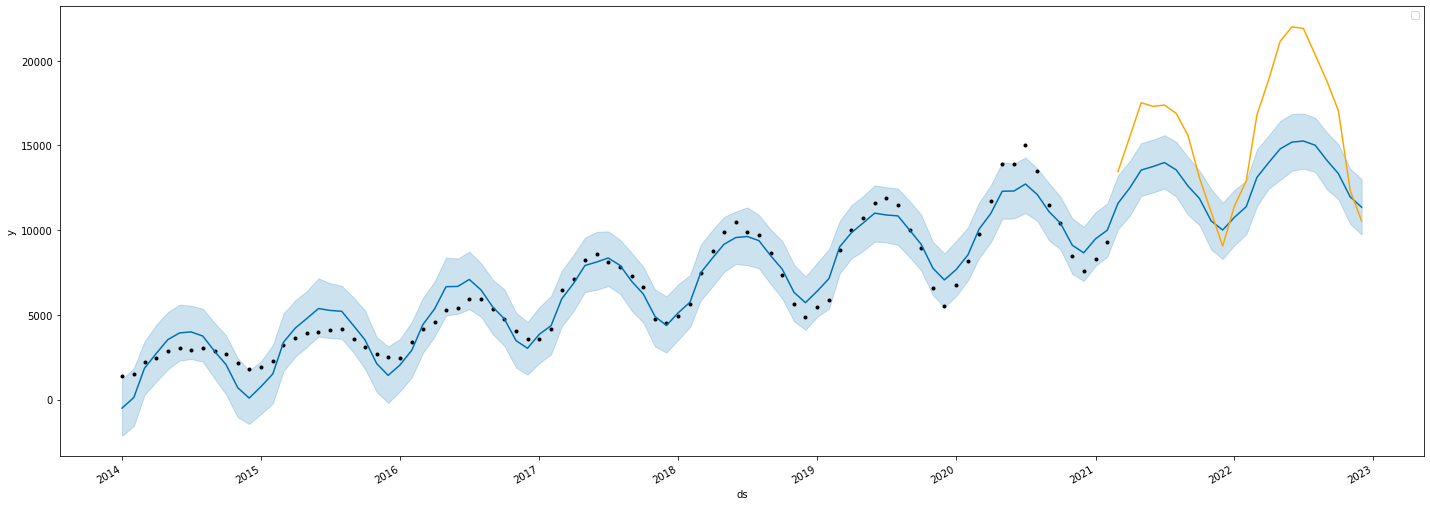

In [215]:
# Plot our prophet_forecast predictions
fig, ax =plt.subplots(figsize=(20,8))

#Plot Prophet predictions on train and test values in BLUE
p_graph = prophet_model.plot(prophet_predict, ax=ax, uncertainty=True)
p_graph.set_label('Prophet Predictions')

# Plot Test data in ORANGE
tp_graph = test_prophet_df.plot(ax=ax, color= 'orange')
tp_graph.set_label('True Values')

ax.legend((p_graph, tp_graph), ('Prophet Predictions', 'True Values'))
plt.show()

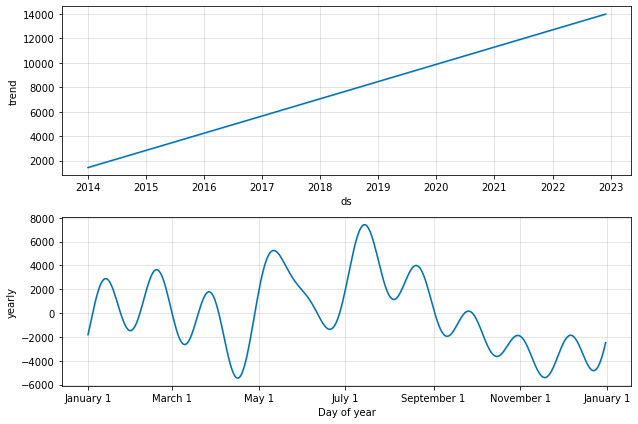

In [216]:
# Plot model components 
prophet_model.plot_components(prophet_predict)
plt.show()

INTERPRETATION OF ABOVE RESULTS

In [217]:
#Turn Prophets yhat predictions into datetime dataframe
prophet_predict.set_index('ds', inplace=True) 
yhat_prophet = prophet_predict['2021-03-01':]['yhat']
yhat_prophet

ds
2021-03-01    11580.881073
2021-04-01    12487.439181
2021-05-01    13545.881841
2021-06-01    13751.970857
2021-07-01    13988.466129
2021-08-01    13553.385040
2021-09-01    12600.751189
2021-10-01    11868.935068
2021-11-01    10536.179116
2021-12-01    10006.445852
2022-01-01    10755.526677
2022-02-01    11384.176828
2022-03-01    13113.032289
2022-04-01    13987.058162
2022-05-01    14795.076176
2022-06-01    15194.002572
2022-07-01    15257.180034
2022-08-01    15011.384591
2022-09-01    14114.958967
2022-10-01    13332.900994
2022-11-01    11961.345328
2022-12-01    11350.906216
Name: yhat, dtype: float64

In [218]:
#Root Mean Square Error(RMSE) for the Prophet model

Prophet_rmse = mean_squared_error(test_prophet_df, yhat_prophet, squared=False)

print(Prophet_rmse)

3761.6733585081083


### Final Model Selection

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [219]:
# code here to show your final model

In [220]:
# code here to evaluate your final model

In [221]:
#Comparison of Models RMSE and AIC
print("MODEL | RMSE| AIC")
print(('Naive', Naive_rmse))
print(('RandWalk', RandWalk_rmse, RandWalk.aic))
print(('AR1', AR1_rmse, AR1.aic))
print(('MA1', MA1_rmse, MA1.aic))
print(('ARMA101', ARMA101_rmse, ARMA101.aic))
print(('AR2', AR2_rmse, AR2.aic))
print(('AR3', AR3_rmse, AR3.aic))
print(('MA2', MA2_rmse, MA2.aic))
print(('MA5', MA5_rmse, MA5.aic))
print(('MA12', MA12_rmse, MA12.aic))
print(('SARIMAX101', SARIMAX101_rmse, SARIMAX101.aic))
print(('ARIMA401', ARIMA401_rmse, ARIMA401.aic))
print(('Prophet', Prophet_rmse))

MODEL | RMSE| AIC
('Naive', 0.05602369702973403)
('RandWalk', 0.12112313353103789, -220.38238059745626)
('AR1', 0.042524002873012424, -261.78134716611714)
('MA1', 0.042222312488392796, -262.8956823232826)
('ARMA101', 0.04153042528185087, -263.4520990255252)
('AR2', 0.041720671820569474, -262.70610587485197)
('AR3', 0.041676805436199296, -260.86670679708965)
('MA2', 0.041325678553057306, -264.17158841635353)
('MA5', 0.03992607447706315, -263.7648866141082)
('MA12', 0.03716449756236158, -262.2139968703441)
('SARIMAX101', 0.11647437239876243, -248.35482591094006)
('ARIMA401', 0.039335693141373695, -266.14277720741296)
('Prophet', 3761.6733585081083)


**Root Mean Squared Error (RMSE)** is a metric measuring 

**Akaike’s Information Criterion (AIC)** is a helpful metric that estimates prediction error and so can be used for determining the strength of the linear regression model. The AIC balances finding the best goodness of fit and penalizeing a model with more parameters (since adding parameters increases the liklihood of overfitting). It is a relative score where a lower AIC values is better.  

Based on the scores of our models above, our best model seems to be **'ARIMA401'** as it has the second lowest train RMSE and the best AIC score. 

## Evaluation

Let's look more at our final model, the ARIMA(4,0,1)

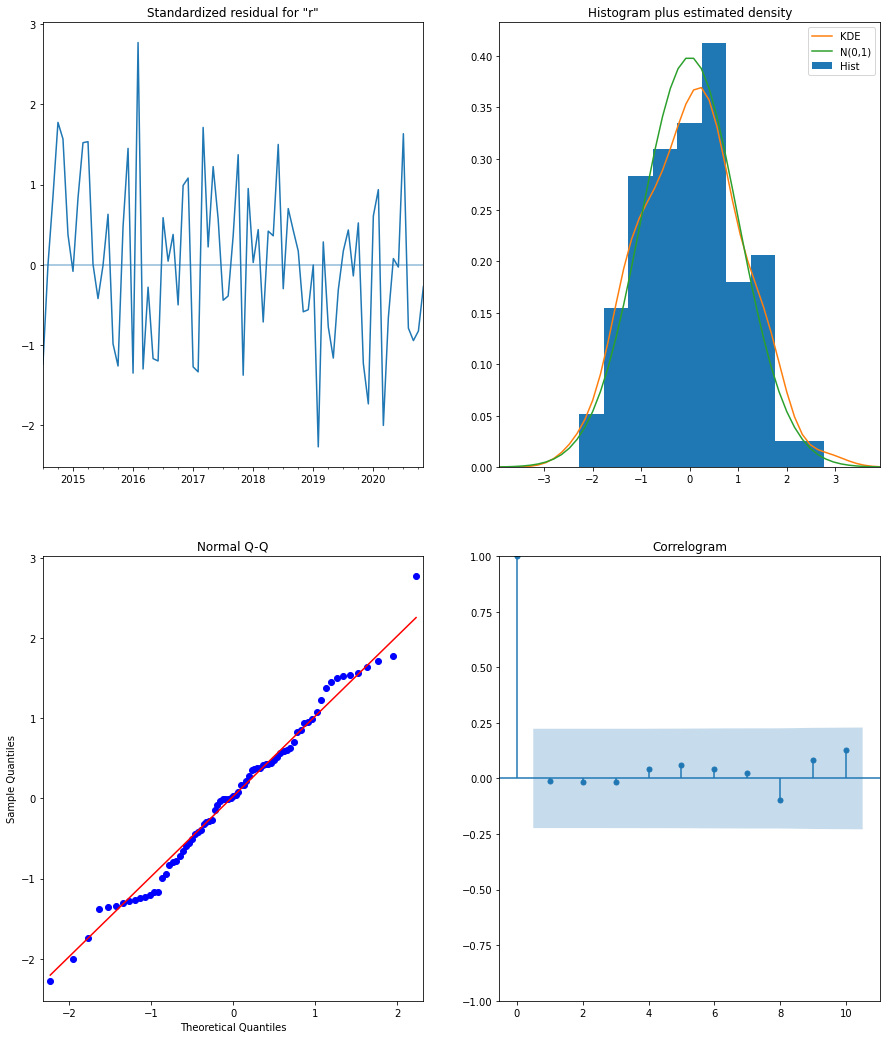

In [222]:
# Call plot_diagnostics() on the final model
ARIMA401.plot_diagnostics(figsize=(15, 18))
plt.show()

INTERPRETATION OF ABOVE RESULTS

### Test

Now we have our tuned model predict on our test data to see how well our model is performing on unseen data. 

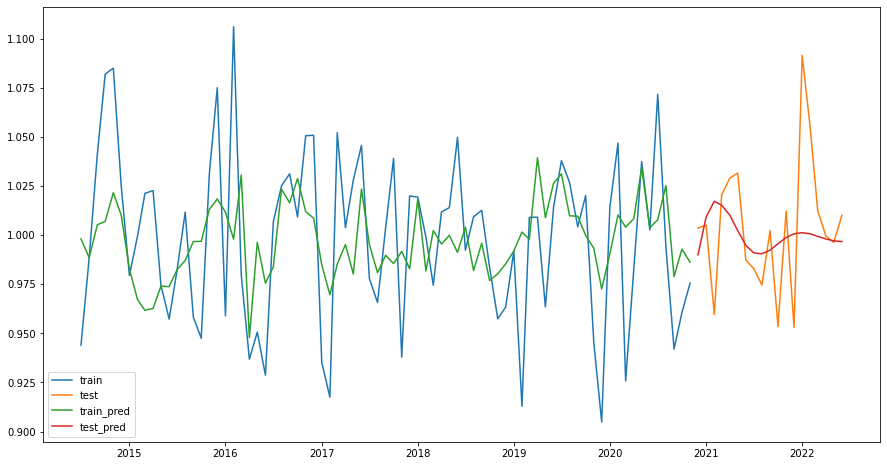

In [223]:
y_hat_train = ARIMA401.predict(typ='levels')
y_hat_test = ARIMA401.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

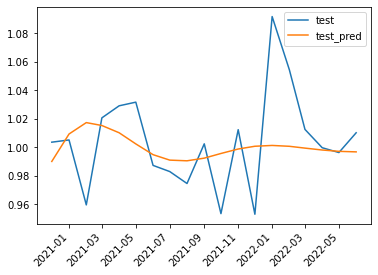

In [224]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='test')
ax.plot(y_hat_test, label='test_pred')
plt.xticks(rotation = 45, ha='right');

plt.legend();

In [225]:
#Root Mean Square Error(RMSE) For our test data with our final model
print(mean_squared_error(test, y_hat_test, squared=False))

0.033116607811952324


**Mean Absolute Percentage Error (MAPE)** is another useful evaluation metric that gives us the average percentage error of our predictions over the enrire time period. For example, a 5% MAPE would mean that our predictions are off 5% on average from the actual values. Ideally, we want as low a MAPE as possible.

In [226]:
#Define a function for calculating MAPE
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [227]:
#MAPE for our ARIMA401 Test
mape(test, y_hat_test)

2.32

Our Test RMSE of 0.033 is even lower than our Train RMSE which is a good sign. This mean our data has an error of 0.033 thousand megawatthours (i.e. 33 megawatthours). <br>
<br>
Our MAPE is 2.32% which is very low and indicates a good model. This means our predictions are off by an average of only 2.32%.

### Forecast

After predicting on our test data, we now want to retrain the model (using the same parameters) on the entirety of the data we have so we can make predictions for the future. 

#### ARIMA Forecast

In [106]:
#Train final forecasting model on all data
forecast_model = ARIMA(us_solar_df,
                       order=(4, 0, 1)).fit()

In [107]:
#Forecast 1 year (12 months) forward
forecast = forecast_model.forecast(steps=12)

In [108]:
#Let's look at our forecasted values
forecast

2023-01-01     8973.528185
2023-02-01     9830.857837
2023-03-01    11659.574438
2023-04-01    14615.120835
2023-05-01    17484.020957
2023-06-01    19796.501485
2023-07-01    20846.629418
2023-08-01    20526.950798
2023-09-01    18930.269011
2023-10-01    16555.462514
2023-11-01    14014.571940
2023-12-01    11962.421825
Freq: MS, Name: predicted_mean, dtype: float64

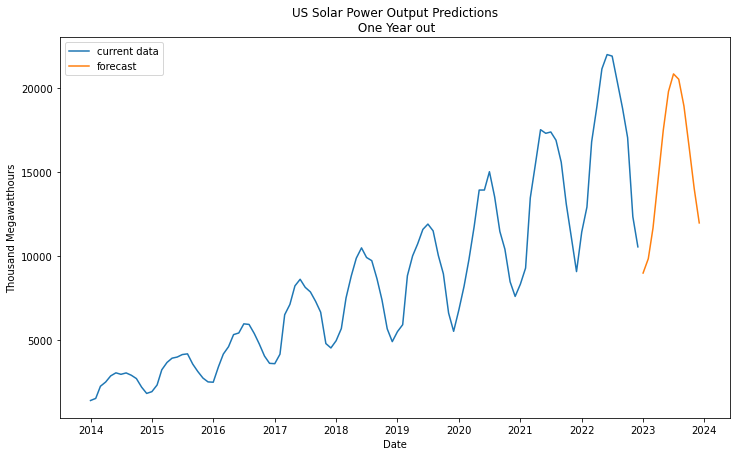

In [109]:
#Plot our current data along with our 12 month forecast
fig, ax = plt.subplots(figsize =(12,7))
ax.plot(us_solar_df, label='current data')
ax.plot(forecast, label='forecast')

ax.set_title('US Solar Power Output Predictions\n One Year out')
ax.set_xlabel('Date')
ax.set_ylabel('Thousand Megawatthours')

plt.legend();

#### One-step Ahead and Dynamic Forecasting

In [110]:
# Get one-step ahead predictions starting from 01-01-2023 and calculate confidence intervals
onestep_pred = forecast_model.get_prediction(start= pd.to_datetime('2022-01-01'), 
                                     end= pd.to_datetime('2024-01-01'),
                                     dynamic=False)

onestep_pred_conf = onestep_pred.conf_int()


# Get dynamic predictions with confidence intervals as above 
pred_dynamic = forecast_model.get_prediction(start= pd.to_datetime('2022-01-01'), 
                                     end= pd.to_datetime('2024-01-01'),
                                     dynamic=True,
                                     full_results=True)

pred_dynamic_conf = pred_dynamic.conf_int()

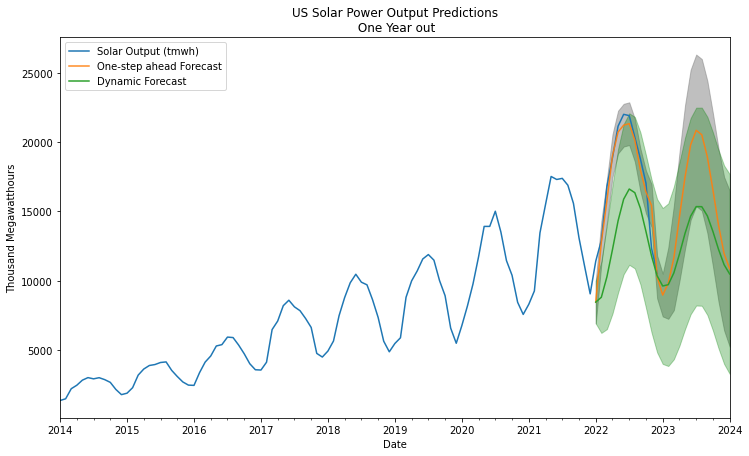

In [111]:
# Plot real vs predicted values along with confidence interval

fig, ax = plt.subplots(figsize =(12,7))

# Plot observed values
us_solar_df.plot(label='observed', ax=ax)

# Plot one-step ahead predicted values
onestep_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for one-step ahead predictions confidence intervals
ax.fill_between(onestep_pred_conf.index,
                onestep_pred_conf.iloc[:, 0],
                onestep_pred_conf.iloc[:, 1], color='grey', alpha=0.5)

# Plot the dynamic forecast with confidence intervals.
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

# Set axes labels
ax.set_title('US Solar Power Output Predictions\n One Year out')
ax.set_xlabel('Date')
ax.set_ylabel('Thousand Megawatthours')

plt.legend(loc='upper left')
plt.show()

#### Prophet Forecast

In [112]:
#Reset the index as we need dates in a column
prophet_df = us_solar_df.reset_index()

# Rename the columns [index, Solar Output (tmwh)] to [ds, y]
prophet_df = prophet_df.rename(columns={'index': 'ds',
                                              'Solar Output (tmwh)': 'y'})

In [113]:
# Instantiate prophet object. Use an uncertainty interval of 95% (default is 80%)
prophet_model = Prophet(interval_width=0.95)

#Fit our prophet-formatted original data
prophet_model.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [114]:
# Use make_future_dataframe() with a monthly frequency and periods = 12 for 1 year forecast
future_dates = prophet_model.make_future_dataframe(periods=12, freq='MS')
future_dates.tail(12)

ds
108 2023-01-01
109 2023-02-01
110 2023-03-01
111 2023-04-01
112 2023-05-01
113 2023-06-01
114 2023-07-01
115 2023-08-01
116 2023-09-01
117 2023-10-01
118 2023-11-01
119 2023-12-01

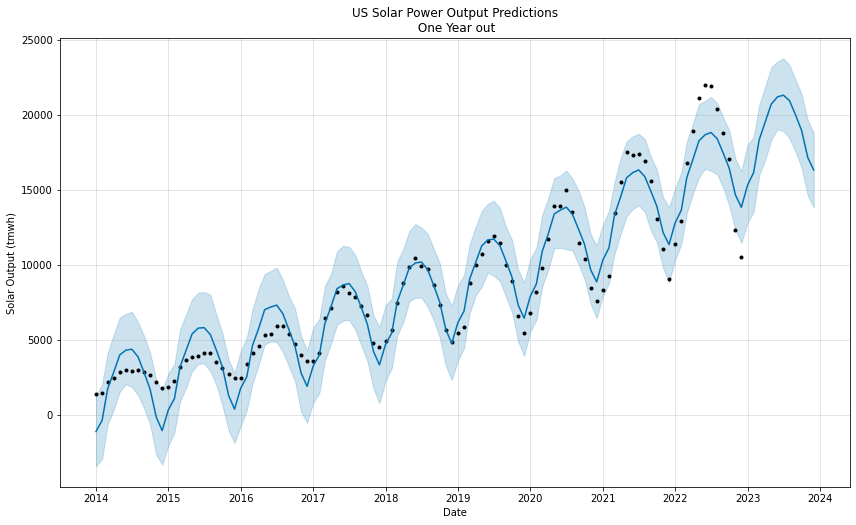

In [115]:
# Predict the values for future dates and take the head of forecast
prophet_forecast = prophet_model.predict(future_dates)

fig, ax = plt.subplots(figsize =(12,7)) 

# Plot our prophet_forecast predictions
p_pred = prophet_model.plot(prophet_forecast, ax=ax, uncertainty=True, 
                            xlabel='Date', 
                            ylabel='Solar Output (tmwh)')


ax.set_title('US Solar Power Output Predictions\n One Year out')

plt.show()

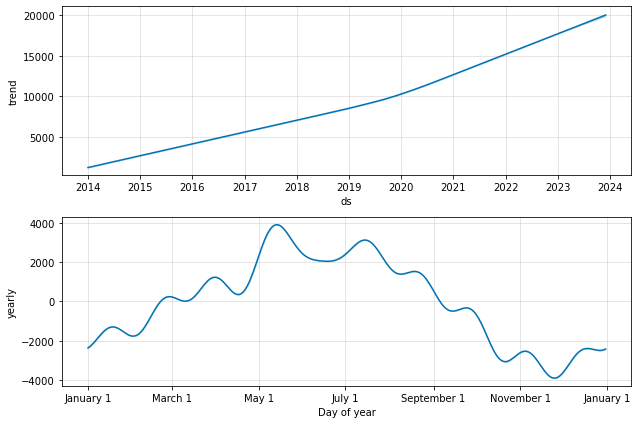

In [116]:
# Plot model components 
prophet_model.plot_components(prophet_forecast)
plt.show()

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?

## Conclusions

I would recommend that NERC consider testing this forecast in the next year and calculating errors to see if the model would be helpful moving forwad. 
<br>
<br>
I would reccommend adding in data on the number on power plants as well as environmental factors (weather, solar irradiation) so the model accounts for more external factors.
<br>
<br>In the future, I would look to repeat this time series modeling and forecasting at the regional and state level in order to provide more actionable data. 